Васильев Семён, 620, варинат 6

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram
from varclushi import VarClusHi

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA

import torch
import torch.nn as nn

In [2]:
#1 Загрузите файл baseball.csv

bb = pd.read_csv('baseball.csv')
bb

,Name,Team,nAtBat,nHits,nHome,nRuns,nRBI,nBB,YrMajor,CrAtBat,...,CrBB,League,Division,Position,nOuts,nAssts,nError,Salary,Div,logSalary
0,"Allanson, Andy",Cleveland,293,66,1,30,29,14,1,293,...,14,American,East,C,446,33,20,NaN,AE,NaN
1,"Ashby, Alan",Houston,315,81,7,24,38,39,14,3449,...,375,National,West,C,632,43,10,475.0,NW,6.163315
2,"Davis, Alan",Seattle,479,130,18,66,72,76,3,1624,...,263,American,West,1B,880,82,14,480.0,AW,6.173786
3,"Dawson, Andre",Montreal,496,141,20,65,78,37,11,5628,...,354,National,East,RF,200,11,3,500.0,NE,6.214608
4,"Galarraga, Andres",Montreal,321,87,10,39,42,30,2,396,...,33,National,East,1B,805,40,4,91.5,NE,4.516339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,"McGee, Willie",St Louis,497,127,7,65,48,37,5,2703,...,138,National,East,CF,325,9,3,700.0,NE,6.551080
318,"Randolph, Willie",New York,492,136,5,76,50,94,12,5511,...,875,American,East,2B,313,381,20,875.0,AE,6.774224
319,"Tolleson, Wayne",Chicago,475,126,3,61,43,52,6,1700,...,146,American,West,3B,37,113,7,385.0,AW,5.953243
320,"Upshaw, Willie",Toronto,573,144,9,85,60,78,8,3198,...,332,American,East,1B,1314,131,12,960.0,AE,6.866933


In [3]:
#2 Обработка пропусков. Переменная Salary (и log Salary) может содержать пропуски,
#  произведите подстановку пропусков методом согласно вашему варианту. Пересчитайте
#  logSalary как log(1+Salary), чтобы получить более симметричное распределение.

def proc_salary(data):
    data['Salary'] = SimpleImputer(
            missing_values=np.nan, strategy='median'
        ).fit_transform(data['Salary'].values.reshape(-1, 1))
    data['logSalary'] = np.log(1 + data['Salary'])
    return data
    
bb = proc_salary(bb)

In [4]:
#3 Нормализация переменных – приведите числовые переменные к близким шкалам с помощью
#  методов для вашего варианта и закодируйте категориальные с помощью OneHotEncoder.

id_fea = 'Name'
cat_feas = ['Div', 'Division', 'League', 'Position', 'Team']
con_feas = [f for f in bb.columns if f not in cat_feas and f != id_fea]

def normalize(data, cat_feas, con_feas):
    data[con_feas] = StandardScaler().fit_transform(data[con_feas])

    for fea in cat_feas:
        enc = OneHotEncoder(sparse=False)
        enc_fea = enc.fit_transform(data[fea].values.reshape(-1, 1))
        data.drop(columns=[fea], inplace=True)
        for i, cat in enumerate(enc.categories_[0]):
            data[f'{fea}_{cat}'] = enc_fea[:, i].astype(int)
            
    return data

bb = normalize(bb, cat_feas, con_feas)
cat_feas = [f for f in bb.columns if f not in con_feas and f != id_fea]
        
bb

,Name,nAtBat,nHits,nHome,nRuns,nRBI,nBB,YrMajor,CrAtBat,CrHits,...,Team_New York,Team_Oakland,Team_Philadelphia,Team_Pittsburgh,Team_San Diego,Team_San Francisco,Team_Seattle,Team_St Louis,Team_Texas,Team_Toronto
0,"Allanson, Andy",-0.677078,-0.847808,-1.163177,-0.888041,-0.800135,-1.227600,-1.346261,-1.062463,-1.042700,...,0,0,0,0,0,0,0,0,0,0
1,"Ashby, Alan",-0.523632,-0.507755,-0.472351,-1.127864,-0.446661,-0.040694,1.273659,0.295038,0.133554,...,0,0,0,0,0,0,0,0,0,0
2,"Davis, Alan",0.620240,0.603083,0.794164,0.550898,0.888687,1.715928,-0.943196,-0.489955,-0.444631,...,0,0,0,0,0,0,1,0,0,0
3,"Dawson, Andre",0.738812,0.852454,1.024440,0.510928,1.124336,-0.135646,0.669062,1.232299,1.265450,...,0,0,0,0,0,0,0,0,0,0
4,"Galarraga, Andres",-0.481783,-0.371734,-0.126938,-0.528306,-0.289561,-0.467980,-1.144729,-1.018159,-0.989165,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,"McGee, Willie",0.745787,0.535072,-0.472351,0.510928,-0.053912,-0.135646,-0.540132,-0.025841,0.089196,...,0,0,0,0,0,0,0,1,0,0
318,"Randolph, Willie",0.710913,0.739103,-0.702626,0.950604,0.024638,2.570500,0.870595,1.181973,1.167557,...,1,0,0,0,0,0,0,0,0,0
319,"Tolleson, Wayne",0.592341,0.512402,-0.932902,0.351046,-0.250286,0.576497,-0.338599,-0.457265,-0.481341,...,0,0,0,0,0,0,0,0,0,0
320,"Upshaw, Willie",1.275874,0.920465,-0.242075,1.310339,0.417388,1.810880,0.064465,0.187075,0.167205,...,0,0,0,0,0,0,0,0,0,1


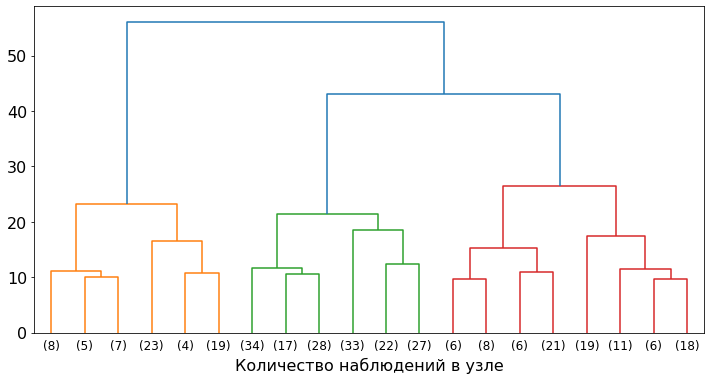

In [5]:
#4 С помощью восходящей иерархической кластеризации с выбранными параметрами
#  расстояния согласно вашему варианту постройте кластерную модель данных и дендрограмму
#  для топ 20 кластеров.

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    font = {'size': 16}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel('Количество наблюдений в узле')

agg_cl = AgglomerativeClustering(
    affinity='euclidean', linkage='ward',
    distance_threshold=0, n_clusters=None
)
agg_cl.fit(bb[con_feas + cat_feas].values)
plot_dendrogram(agg_cl, truncate_mode="lastp", p=20)

Оптимальное в смысле PseudoF число кластеров: 2


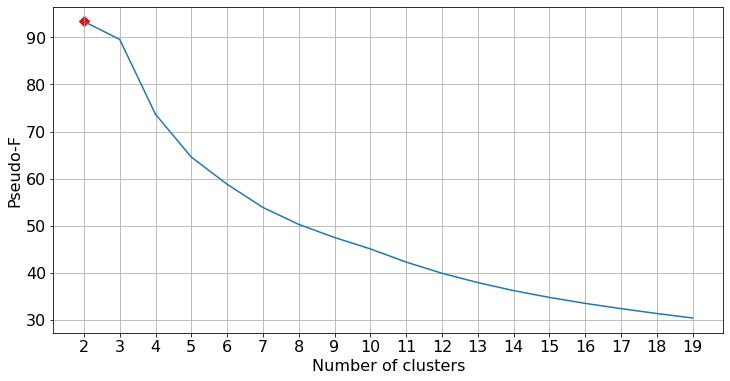

In [6]:
#5 Рассчитайте значение критерия pseudoF для вариантов кластеризации 2-20 кластеров,
#  постройте график зависимости критерия от числа кластеров и выберите оптимальное (первый
#  локальный пик критерия при обходе от малого числа кластеров к большому). Отметьте точку
#  на графике. Сколько кластеров получилось?

def sum_dist_to_center(X):
    center = np.mean(X, axis=0)
    return ((X - center)**2).sum()

def choose_num_cluster(X, max_clust=20):
    N = X.shape[0]
    Q = sum_dist_to_center(X)
    pseudo_f = np.array([])
    for G in range(2, max_clust):
        clustering = AgglomerativeClustering(
            affinity='euclidean', linkage='ward', n_clusters=G
        ).fit(X)
        W = 0
        for l in range(G):
            elems = X[clustering.labels_ == l]
            W += sum_dist_to_center(elems)
        fisher_stat = ((Q - W) / (G - 1)) / (W / (N - G))
        pseudo_f = np.append(pseudo_f, fisher_stat)
    font = {'size': 16}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(12, 6))
    plt.grid()
    plt.plot(range(2, max_clust), pseudo_f)
    ind_best_clust = np.argmax(pseudo_f)
    plt.scatter(ind_best_clust + 2,
                pseudo_f[ind_best_clust],
                color='r', marker='D', s=50)
    plt.xticks(range(2, max_clust))
    plt.xlabel('Number of clusters')
    plt.ylabel('Pseudo-F')
    return ind_best_clust + 2

k = choose_num_cluster(bb[con_feas + cat_feas].values)
print(f'Оптимальное в смысле PseudoF число кластеров: {k}')

In [7]:
agg_cl = AgglomerativeClustering(
    affinity='euclidean', linkage='ward', n_clusters=2
)
agg_cl.fit(bb[con_feas + cat_feas].values)

AgglomerativeClustering()

In [8]:
SEED = 0
EPOCH_N = 4000

100%|██████████████████████████████████████| 4000/4000 [00:25<00:00, 158.43it/s]


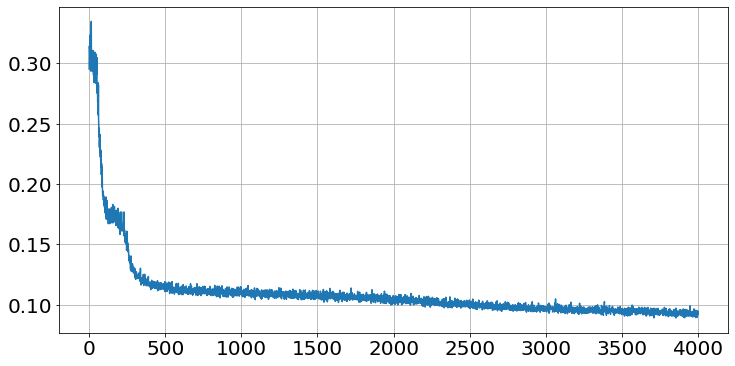

In [9]:
#6 С помощью метода проекции для вашего варианта постройте отображение на плоскость,
#  цветом точки укажите номер кластера.

class AE(nn.Module):
    def __init__(self, shape):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(shape, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, shape),
        )
    
    def forward(self, X):
        return self.decoder(self.encoder(X))
    
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        if self.X.shape[0] != self.y.shape[0]:
            raise ValueError
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def train_encoder(data, epoch_num, con_feas, cat_feas):
    torch.manual_seed(SEED)

    autoencoder = AE(len(con_feas) + len(cat_feas))
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 1e-4, weight_decay = 1e-8)

    X = data[con_feas + cat_feas].values.astype(float)
    dataset = SimpleDataset(torch.FloatTensor(X), torch.FloatTensor(X))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

    losses = []
    for epoch in tqdm(range(epoch_num)):
        full_loss = 0
        c = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            output = autoencoder(X_batch)
            loss = loss_func(X_batch, output)
            full_loss += loss.item()
            c += 1
            loss.backward()
            optimizer.step()
        full_loss /= c
        losses.append(full_loss)

    font = {'size': 20}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(12, 6))
    plt.grid()

    plt.plot(list(range(epoch_num)), losses)
    
    return autoencoder

autoencoder = train_encoder(bb, EPOCH_N, con_feas, cat_feas)

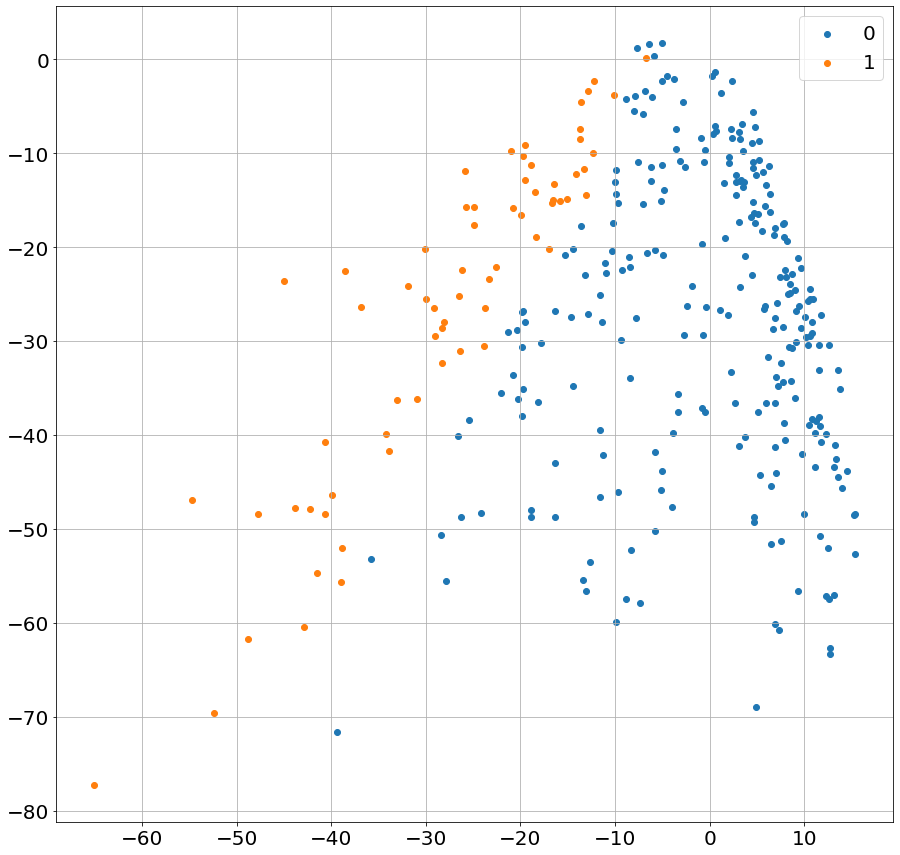

In [10]:
X = bb[con_feas + cat_feas].values.astype(float)
bb_enc = autoencoder.encoder(torch.FloatTensor(X)).detach().numpy()

def plot_clusters(data, labels):
    font = {'size': 20}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(15, 15))
    plt.grid()

    for i in range(np.max(labels) + 1):
        m = (labels == i)
        plt.scatter(data[m, 0], 
                    data[m, 1], 
                    label=f'{i}')
    plt.legend();
    
plot_clusters(bb_enc, agg_cl.labels_)

In [11]:
#7 Выполните кластеризацию сферическими кластерами с прототипом методом из вашего
#  варианта, также постройте проекцию как на шаге 6, определите наиболее типичного
#  представителя (по имени) в каждом из кластеров.

em_cl = GaussianMixture(
    n_components=2, random_state=0, max_iter=100,
).fit(bb[con_feas + cat_feas])
labels = em_cl.predict(bb[con_feas + cat_feas])

Melvin, Bob - center of 0 cluster
[ 11.740886 -40.701397]
Kennedy, Terry - center of 1 cluster
[ -6.206271 -11.416554]


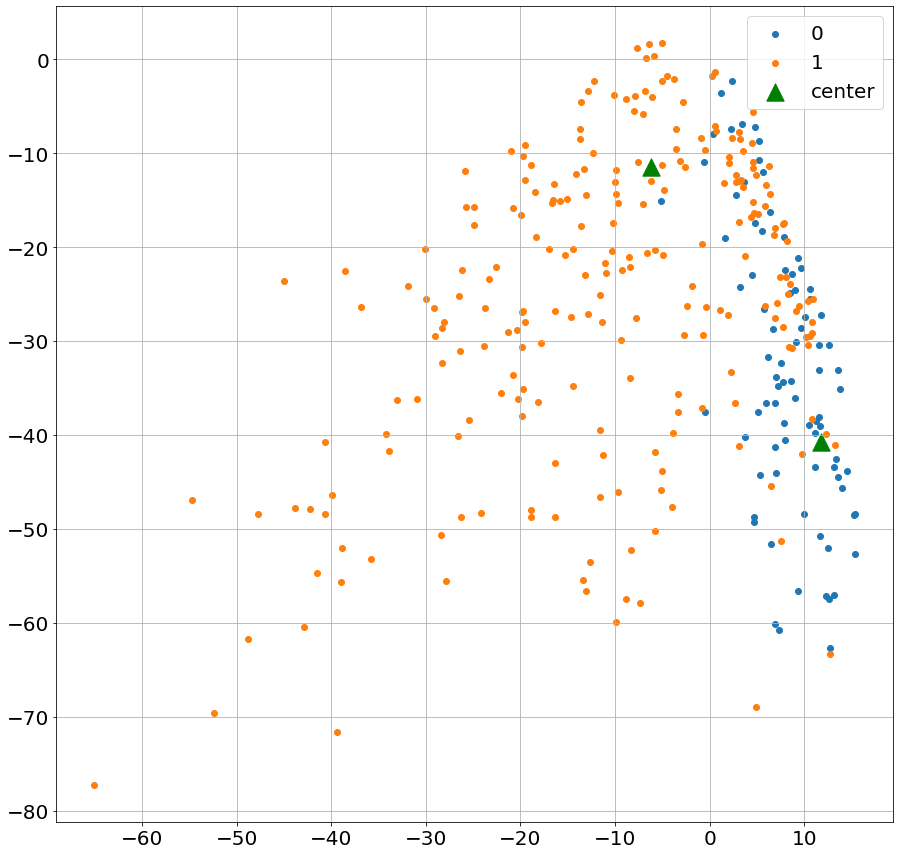

In [12]:
scores = em_cl.score_samples(bb[con_feas + cat_feas])

def find_centers(data, enc, labels, scores):
    centers = []
    for i in range(labels.max() + 1):
        m = (labels == i)
        cl_data = data[m].reset_index(drop=True)
        cl_scores = scores[m]
        cl_enc = enc[m]
        center_idx = np.argmax(cl_scores)
        print(f'{cl_data.loc[center_idx, "Name"]} - center of {i} cluster')
        print(f'{cl_enc[center_idx]}')
        centers.append(cl_enc[center_idx])
    return np.array(centers)
        
centers = find_centers(bb, bb_enc, labels, scores)

plot_clusters(bb_enc, labels)
plt.scatter(centers[:,0], centers[:,1], c='green', marker='^', s=300, label='center')
plt.legend();

In [27]:
#8 Реализуйте шаги 3-7 в виде функции или класса. 

def all_steps(
        data,
        id_fea='Name',
        cat_feas=['Div', 'Division', 'League', 'Position', 'Team']
    ):
    if 'Salary' in data.columns:
        data = proc_salary(data)
    
#     id_fea = 'Name'
#     cat_feas = ['Div', 'Division', 'League', 'Position', 'Team']
    con_feas = [f for f in data.columns if f not in cat_feas and f != id_fea]
    
    data = normalize(data, cat_feas, con_feas)
    
    cat_feas = [f for f in data.columns if f not in con_feas and f != id_fea]
    
    k = choose_num_cluster(data[con_feas + cat_feas].values)
    print(f'Оптимальное в смысле PseudoF число кластеров: {k}')
    
    autoencoder = train_encoder(data, EPOCH_N, con_feas, cat_feas)
    
    X = data[con_feas + cat_feas].values.astype(float)
    data_enc = autoencoder.encoder(torch.FloatTensor(X)).detach().numpy()
    
    em_cl = GaussianMixture(
        n_components=k, random_state=1, max_iter=100,
    ).fit(data[con_feas + cat_feas])
    labels = em_cl.predict(data[con_feas + cat_feas])

    scores = em_cl.score_samples(data[con_feas + cat_feas])
    centers = find_centers(bb, bb_enc, labels, scores)

    plot_clusters(bb_enc, labels)
    plt.scatter(centers[:,0], centers[:,1], c='green', marker='^', s=300, label='center')
    plt.legend();

In [14]:
# 9

bb_01 = pd.read_csv('baseball.csv')
bb_01.skew()

/tmp/ipykernel_10841/4111928305.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bb_01.skew()


nAtBat       0.075986
nHits        0.423384
nHome        0.919207
nRuns        0.509917
nRBI         0.704760
nBB          0.689484
YrMajor      0.716007
CrAtBat      1.164102
CrHits       1.295944
CrHome       2.135479
CrRuns       1.352553
CrRbi        1.459407
CrBB         1.733534
nOuts        2.065057
nAssts       1.358483
nError       1.055453
Salary       1.588967
logSalary   -0.182007
dtype: float64

In [15]:
skew_feas = ['CrHome', 'nOuts', 'CrBB', 'nAssts', 'CrRbi']
for f in skew_feas:
    bb_01[f] = np.log(1 + bb_01[f])
bb_01.skew()

/tmp/ipykernel_10841/1493035487.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bb_01.skew()


nAtBat       0.075986
nHits        0.423384
nHome        0.919207
nRuns        0.509917
nRBI         0.704760
nBB          0.689484
YrMajor      0.716007
CrAtBat      1.164102
CrHits       1.295944
CrHome      -0.412006
CrRuns       1.352553
CrRbi       -0.372350
CrBB        -0.323666
nOuts       -2.202470
nAssts      -0.227662
nError       1.055453
Salary       1.588967
logSalary   -0.182007
dtype: float64

Оптимальное в смысле PseudoF число кластеров: 2


100%|██████████████████████████████████████| 4000/4000 [00:25<00:00, 156.62it/s]


Daulton, Darren - center of 0 cluster
[ 10.607768 -24.485939]
DeCinces, Doug - center of 1 cluster
[-28.338135 -32.298786]


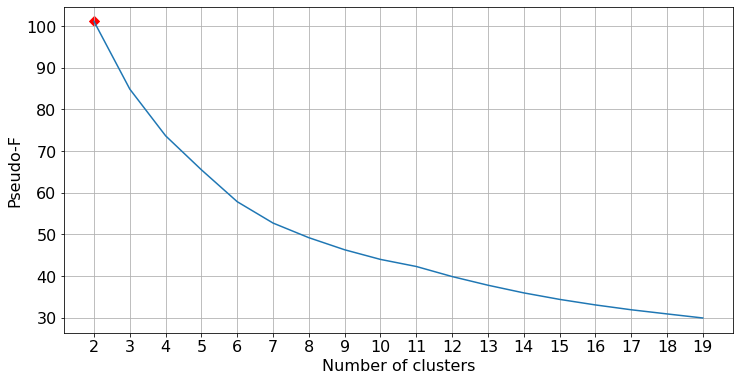

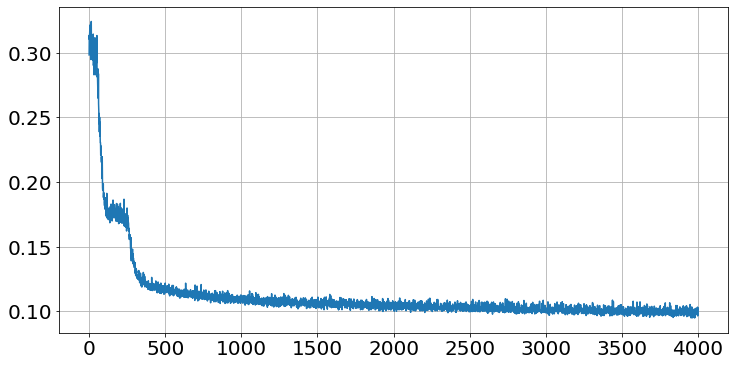

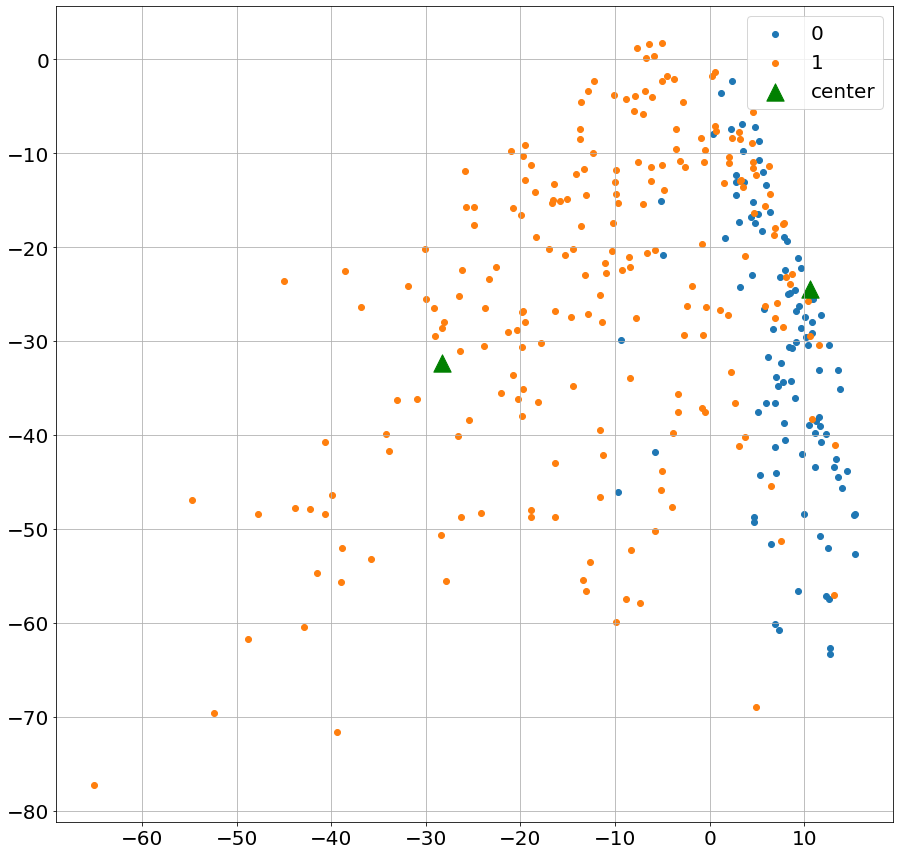

In [16]:
all_steps(bb_01)

Число кластеров не изменилось. В области кластера 0 стало меньше объектов кластера 1. Центр кластера 1 на проекции переместился вглубь кластера. Из-за лучшей разделимости и отдаления центров, кажется, что кластеризация после преобразований стала лучше, но незначительно.

In [17]:
# 10

vc = VarClusHi(bb[cat_feas + con_feas], maxclus=6)
vc.varclus()
vc.rsquare.sort_values("RS_Ratio").groupby("Cluster").first()

,Variable,RS_Own,RS_NC,RS_Ratio
Cluster,,,,
0,CrRuns,0.952416,0.079044,0.051668
1,nRuns,0.865637,0.044340,0.140597
2,Division_East,0.852847,0.464081,0.274580
3,nAssts,0.849000,0.030862,0.155808
4,Div_NE,0.610569,0.041621,0.406343
5,Div_NW,0.750440,0.246406,0.331160


Оптимальное в смысле PseudoF число кластеров: 4


100%|██████████████████████████████████████| 4000/4000 [00:24<00:00, 164.44it/s]


Santana, Rafael - center of 0 cluster
[  6.5206738 -45.409523 ]
Parrish, Lance - center of 1 cluster
[-18.326782 -18.908047]
Balboni, Steve - center of 2 cluster
[-12.684245 -53.493225]
Mulliniks, Rance - center of 3 cluster
[ 0.58721435 -7.083003  ]


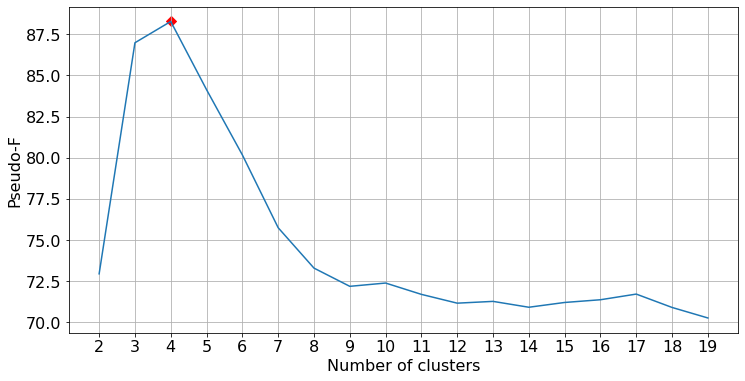

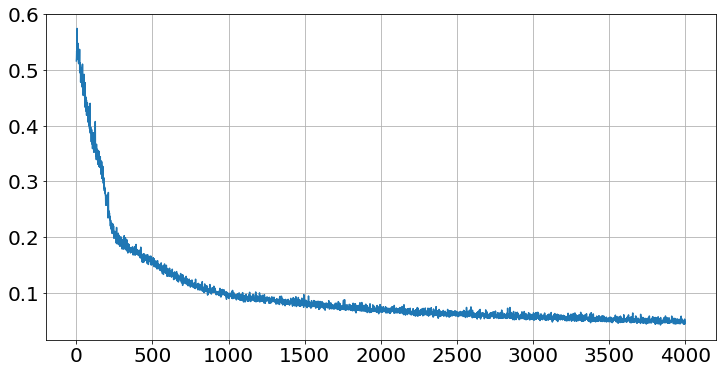

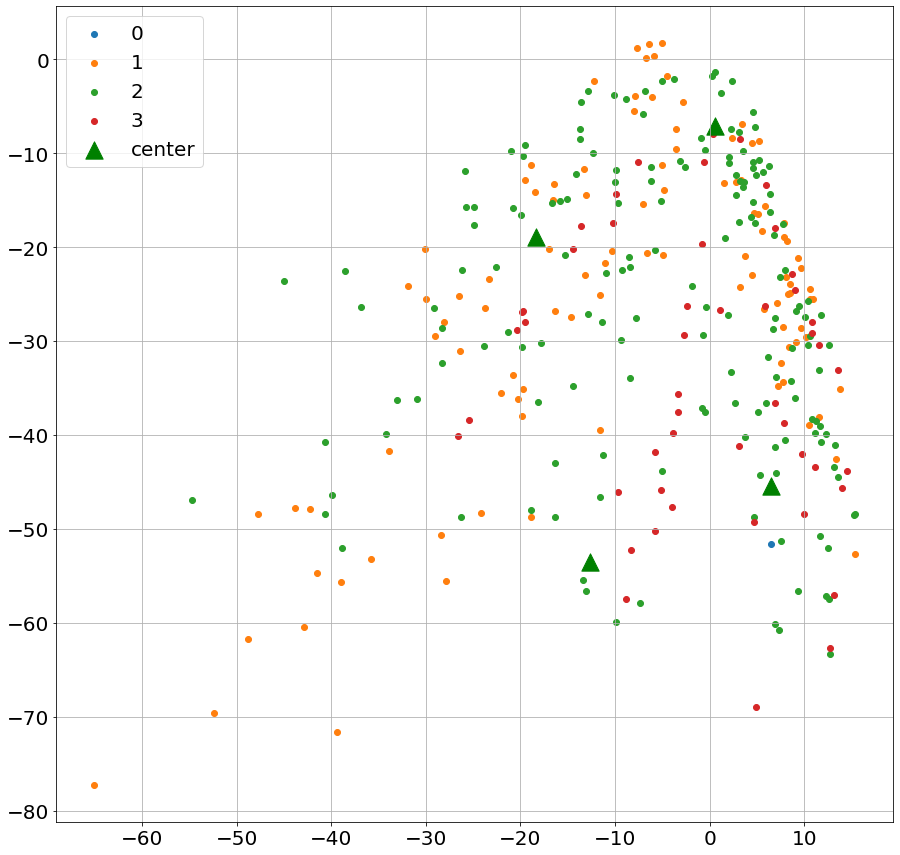

In [28]:
bb_02 = pd.read_csv('baseball.csv')[['CrRuns', 'nRuns', 'Division', 'nAssts', 'Div']]
all_steps(bb_02, cat_feas=['Division', 'Div'])

Число кластеров увеличилось с 2 до 4. Кластеризация стала значительно хуже, кластеры перемешаны, на проекции выглядит неразделимыми.

In [19]:
#11 12

mnist = pd.read_csv('mnist_small.csv')
X = mnist[mnist.columns[1:]].values.astype(float) / 255
y = (mnist['label'] == 6).astype(int)
mnist

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5995,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5997,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
def EER(true, pred):
    fpr, tpr, thr = roc_curve(true, pred, pos_label=1)
    fnr = 1 - tpr
    eer_thr = thr[np.nanargmin(np.absolute(fnr - fpr))]
    EER = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    
    print(EER)
    font = {'size': 20}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(12, 12))
    plt.grid()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [1, 0])
    plt.scatter([EER], [1 - EER], marker='^', s=200, c='red')
    
    return EER

0.12662502110417018


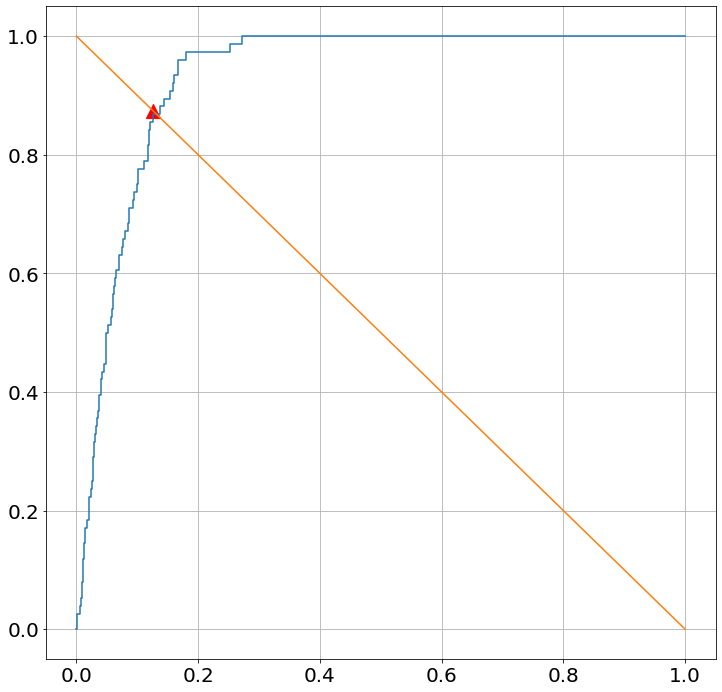

In [30]:
nbrs = NearestNeighbors(n_neighbors=len(X))
nbrs.fit(X)
dist, idx = nbrs.kneighbors(X)
score = dist.mean(axis=1)
EER(y, score);

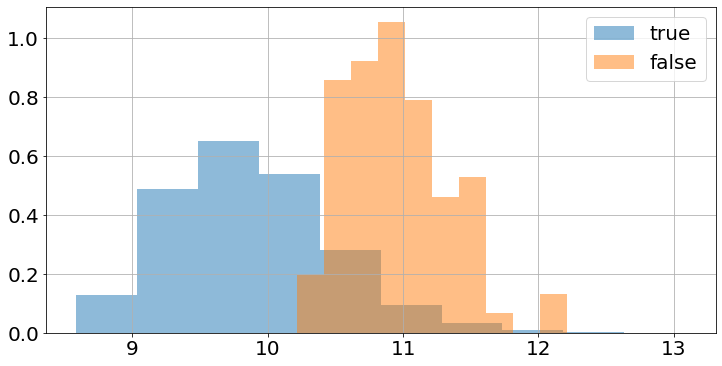

In [22]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 6))
plt.grid()

plt.hist(score[y == 0], label='true', density=True, alpha=0.5)
plt.hist(score[y == 1], label='false', density=True, alpha=0.5)
plt.legend();

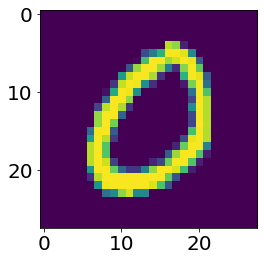

In [23]:
m = (y == 0)
max_norm = X[m][np.argmin(score[m]),:].reshape(28,28) * 255
plt.imshow(max_norm)

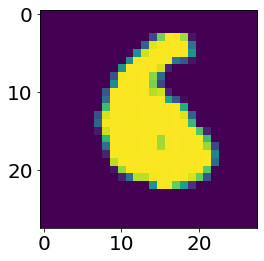

In [24]:
max_anom = X[~m][np.argmax(score[~m]),:].reshape(28,28) * 255
plt.imshow(max_anom)

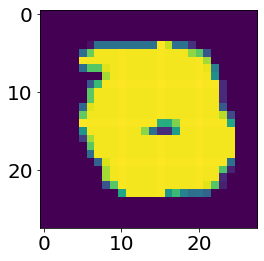

In [25]:
min_norm = X[m][np.argmax(score[m]),:].reshape(28,28) * 255
plt.imshow(min_norm)

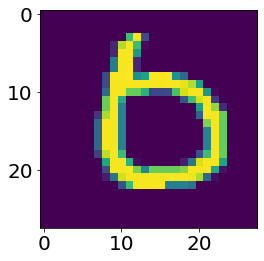

In [26]:
min_anom = X[~m][np.argmin(score[~m]),:].reshape(28,28) * 255
plt.imshow(min_anom)